In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.imports import *
from fastai.transforms import *
from fastai.plots import *
from fastai.structured import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
if torch.cuda.is_available():
    display("Cuda enabled")
    torch.cuda.set_device(0)
    use_cuda = True
else:
    display("Cuda not enabled")
    use_cuda = False

'Cuda enabled'

## Preprocessing: Data Augmentation

We're going to be using a subset fo the [Microsoft COCO](http://cocodataset.org/#download) to train our model

In [3]:
PATH = Path('data/')
RAW_IMAGES = PATH/'raw'
TRAIN_IMAGES = PATH/'train/images'
TRAIN_CSV = PATH/'train/rotation.csv'

In [4]:
# Source: https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

In [5]:
def gen_rand_file_name():
    return ''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(15)) + '.jpg'

In [6]:
train_files = glob(str(TRAIN_IMAGES) + '/*')
for f in train_files:
    os.remove(f)

In [7]:
img_files = os.listdir(RAW_IMAGES)

MAX_ROTATION_ABS = 45 # rotate no more than 45 degrees
NUM_AUGMENTATIONS = 1
IMAGE_SIZE = 224 # 256
name_to_rotation = {}

total = 0

print(f'Processing {len(img_files)} images.')
for img_file in img_files:
    if total % 200 == 0:
        print(f'{total} processed.')
    for i in range(NUM_AUGMENTATIONS):
        rotation_deg = (random.random() * MAX_ROTATION_ABS * 2) - MAX_ROTATION_ABS

        img = plt.imread(RAW_IMAGES/img_file)
        img = Image.fromarray(img)
        img = img.resize((IMAGE_SIZE*2, IMAGE_SIZE*2))
        img = np.array(img)
        
        image_height, image_width = img.shape[0:2]

        new_image = rotate_image(img, rotation_deg)
        new_image = crop_around_center(
            new_image,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(rotation_deg)
            )
        )
        if len(new_image.shape) != 3 or new_image.shape[2] != 3:
            continue # TODO: Allow for black and white examples
        file_name = gen_rand_file_name()
        save_image = Image.fromarray(new_image)
        save_image = save_image.resize((IMAGE_SIZE, IMAGE_SIZE))
        save_image.save(TRAIN_IMAGES/file_name)
        name_to_rotation[file_name] = -rotation_deg
    total += 1


Processing 4968 images.
0 processed.
200 processed.
400 processed.
600 processed.
800 processed.
1000 processed.
1200 processed.
1400 processed.
1600 processed.
1800 processed.
2000 processed.
2200 processed.
2400 processed.
2600 processed.
2800 processed.
3000 processed.
3200 processed.
3400 processed.
3600 processed.
3800 processed.
4000 processed.
4200 processed.
4400 processed.
4600 processed.
4800 processed.


In [8]:
dataframe = pd.DataFrame.from_dict(
    name_to_rotation,
    orient='index',
)
dataframe = dataframe.reset_index()
dataframe.columns = ['filename', 'rotation']
dataframe = dataframe.set_index('filename')
dataframe.to_csv(TRAIN_CSV)
dataframe = dataframe.reset_index()

In [9]:
dataframe.head()

,filename,rotation
0,xqj8p5y9fel0qno.jpg,20.142252
1,vkc4nst3hgi4d0j.jpg,-29.280169
2,fp90iu06g2t7iba.jpg,3.760109
3,fanlx75bnfvclbt.jpg,-1.138901
4,c91eg7usqt8706u.jpg,-38.628662


20.142252060645596

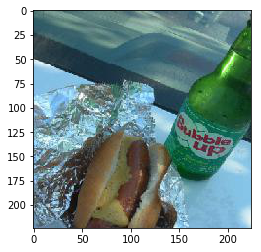

In [10]:
test_image = plt.imread(TRAIN_IMAGES/dataframe.filename[0])
display(plt.imshow(test_image))
display(dataframe.rotation[0])

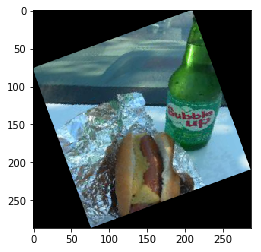

In [11]:
plt.imshow(rotate_image(test_image, dataframe.rotation[0]))

## Setup Training

In [12]:
dataframe = pd.read_csv(TRAIN_CSV)
dataframe.head()

,filename,rotation
0,xqj8p5y9fel0qno.jpg,20.142252
1,vkc4nst3hgi4d0j.jpg,-29.280169
2,fp90iu06g2t7iba.jpg,3.760109
3,fanlx75bnfvclbt.jpg,-1.138901
4,c91eg7usqt8706u.jpg,-38.628662


In [13]:
training_mask = np.random.rand(len(dataframe)) < .9

In [14]:
train = dataframe[training_mask].reset_index()
validation = dataframe[~training_mask].reset_index()

In [15]:
len(train), len(validation), len(dataframe)

(4461, 497, 4958)

In [16]:
class RotationDataset(Dataset):
    def __init__(self, dataframe):
        self.file_names = dataframe.filename
        self.rotations = dataframe.rotation
        
    def __len__(self): return len(self.file_names)
    
    def __getitem__(self, i):
        file_name, y = self.file_names[i], self.rotations[i]
        image_data = plt.imread(TRAIN_IMAGES/file_name).astype('int16')
        image_data = np.moveaxis(image_data, 2, 0)
        return (
            image_data,
            y
        )

In [17]:
train_dataset = RotationDataset(train)
val_dataset = RotationDataset(validation)

In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size = 64,
    num_workers=4
)
validation_loader = DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=4,
)

In [ ]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

In [ ]:
class RotationNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input - 3@256x256
        self.conv1 = StdConv(3, 16)
        # 16@128x128
        self.conv2 = StdConv(16, 32)
        # 32@64x64
        self.conv3 = StdConv(32, 64)
        # 64@32x32
        self.conv4 = StdConv(64, 128)
        # 128@16x16
        self.fc1 = nn.Linear(128*16*16, 120)
        self.fc2 = nn.Linear(120, 1)#60)
        #self.fc3 = nn.Linear(60, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
net = RotationNet()

In [19]:
from torchvision import models

In [29]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 1)
if use_cuda:
    print("Using cuda")
    resnet = resnet.cuda()

Using cuda


In [ ]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=.001)
loss_func = torch.nn.L1Loss()

EPOCHS = 6

for t in range(EPOCHS):
    resnet.train(True)
    running_loss_train = 0
    total = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()   # clear gradients for next train
        X, y = batch
        X = Variable(X.float().cuda())
        y = Variable(y.float().cuda())
        prediction = resnet(X)     # input x and predict based on x
        loss = loss_func(prediction.squeeze_(), y.squeeze())     # must be (1. nn output, 2. target)
        running_loss_train += loss.data[0] * len(y)
        total += len(y)
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    train_loss = running_loss_train / total
    print(f"Training Loss: {train_loss}")
    
    resnet.train(False)
    running_loss_val = 0
    total = 0
    for i, batch in enumerate(validation_loader):
        X, y = batch
        X = Variable(X.float().cuda())
        y = Variable(y.float().cuda())
        prediction = resnet(X)     # input x and predict based on x
        val_loss = loss_func(prediction.squeeze_(), y.squeeze_())     # must be (1. nn output, 2. target)
        running_loss_val += val_loss.data[0] * len(y)
        total += len(y)
        
    validation_loss = running_loss_val / total
    print(f"Validation Loss: {validation_loss}")

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training Loss: 12.792903900146484


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Loss: 12.312372207641602
Training Loss: 10.201132774353027
Validation Loss: 10.75208568572998
Training Loss: 8.90971565246582
Validation Loss: 10.04845142364502
Training Loss: 8.022247314453125
Validation Loss: 9.562661170959473
Training Loss: 7.341166019439697
Validation Loss: 9.449312210083008
